This notebook is my first experience with Generative Adversial Networks(GAN). I'm taking part in the competition on kaggle around Monet: https://www.kaggle.com/competitions/gan-getting-started. This notebook is published on github (https://github.com/Pdegoffau/kaggle-GAN-Monet). The challenge is to create a system which can transform photos into images that look like paintings from Monet. This can be done by using a GAN.

# Generative Adversial Networks
Generative Adversial Networks (GAN) are neural networks that are designed to generate new content. To create this system a discriminator, generator and a loss function is needed. The generator will generate new content. The discriminator will evaluate if the content is fake or not. By using a proper loss function the generator can be trained to fool the discriminator to classify the generated content as true (instead of fake).

## CycleGAN
A specific version of GANs is CycleGAN, which is a network with a cycle layout. This is used for the situation where you want to transfer content from one class to another class, having examples for both classes, but none of them a direct translation. Like in this challenge, 'normal' photos have been supplied as well as paintings by Monet. However, there is no direct relation between the provided photos and paintings. In order to be able to transform photos into paintings in the right style, we need a generator and a discriminator. However, how are we going to train them? For that we would need training data, but we don't have one-on-one translations available. In order to enable training we can use another generator and discriminator to transform monet paintings to photos. This gives the possibility to define a loss function for the full flow through generator-1, discriminator-1, generator-2 and discriminator-2. 

In this notebook we will first evaluate the provided images and read them in memory. After that we will construct and train the cycleGAN using Keras. Finally the system will be applied to the provided photos and the result will be submitted on the Kaggle competition.

# Load data
Credits for the loading procedure must go to Amy Jang on her tutorial: (https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial#Introduction-and-Setup)

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [2]:
input_path = 'input/'

MONET_FILENAMES = tf.io.gfile.glob(str(input_path + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(input_path + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    # Use 3 layers for RGB
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    # read image (as jpeg)
    example = tf.io.parse_single_example(example, tfrecord_format)
    # transform to tfrecord
    image = decode_image(example['image'])
    return image

In [8]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

In [9]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

Check if the loading has gone well by displaying examples from both sets.

In [10]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

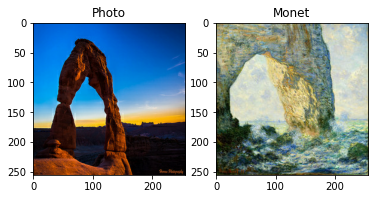

In [13]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

Good, now the images are loaded, so we can proceed by defining the models, loss function and glue it together to see how it performs.

# Building the cycle network